# Step 4.5: Visualizing individual traces clustering

__Step goals:__ Visualize obtained individual traces clusters over time and space.

__Step overview:__
1. Load the data;
2. Visualize clusters as set of time-series data;
3. Construct the data for ternary diagram;
4. Visualize clusters with ternary diagram;
5. Explore obtained clustering parameters.

In [5]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import geopandas as gpd
import numpy as np
from math import sqrt
from scipy import stats
from tqdm import tqdm
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
plt.style.use('science')

In [6]:
matplotlib.rcParams['font.size']

10.0

In [7]:
font = {'size' : 12}
matplotlib.rc('font', **font)

## 1. Load the data

In [8]:
%%time
# Load the data
n_components = 6
data_type = 'entry'

labels = np.load(f"../data/interim/gmm/individual_traces/labels_{n_components}_{data_type}.npy", allow_pickle=True)
weights = np.load(f"../data/interim/gmm/individual_traces/weights_{n_components}_{data_type}.npy", allow_pickle=True)
probs = np.load(f"../data/interim/gmm/individual_traces/probs_{n_components}_{data_type}.npy", allow_pickle=True)
means = np.load(f"../data/interim/gmm/individual_traces/means_{n_components}_{data_type}.npy", allow_pickle=True)
covariances = np.load(f"../data/interim/gmm/individual_traces/covariances_{n_components}_{data_type}.npy", allow_pickle=True)

entry_station_cluster = gpd.read_file('../data/interim/counts/entry_station_cluster.json')

entry_individual = pd.read_csv("../data/interim/counts/entry_individual.csv")
entry_individual['label'] = labels
entry_individual = entry_individual.reset_index(drop=True)

Wall time: 3.24 s


## 2. Visualize individual traces as as a mixture of Gaussian distributions over time

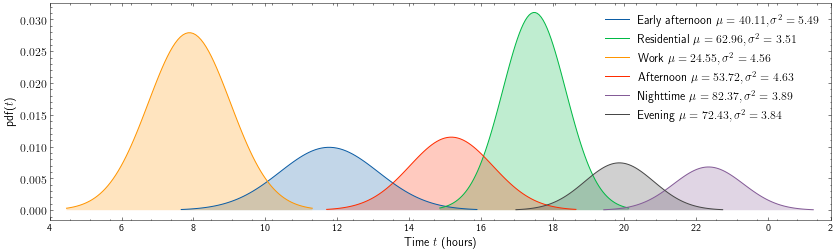

In [6]:
# Prepare the parameters for plotting
sigmas = [sqrt(covariance) for covariance in covariances]
counts = pd.DataFrame(labels)[0].value_counts().sort_index()
heights = counts.div(counts.sum())

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
x_ticks = [0, 9, 17, 25, 33, 41, 49, 57, 65, 73, 81, 89, 96]
x_ticks_labels = ["2", "4", "6", "8", "10", "12", "14", "16", "18", "20", "22", "0", "2"]
# x_ticks_labels = ["04:00", "06:00", "08:00","10:00", "12:00", "14:00", "16:00", "18:00", "20:00", "22:00", "00:00"]

# For 5 clusters
# label_names = ["Travelling home", "Travelling to work", "Nighttime travelers", "Afternoon", "Early afternoon"]
# r'$\overline P(t)$ (x1000)'
# For 6 clusters
label_names = [f"Early afternoon $\mu = {round(means[0][0], 2)}, \sigma^2 = {round(sigmas[0], 2)}$", 
               f"Residential $\mu = {round(means[1][0], 2)}, \sigma^2 = {round(sigmas[1], 2)}$", 
               f"Work $\mu = {round(means[2][0], 2)}, \sigma^2 = {round(sigmas[2], 2)}$", 
               f"Afternoon $\mu = {round(means[3][0], 2)}, \sigma^2 = {round(sigmas[3], 2)}$", 
               f"Nighttime $\mu = {round(means[4][0], 2)}, \sigma^2 = {round(sigmas[4], 2)}$", 
               f"Evening $\mu = {round(means[5][0], 2)}, \sigma^2 = {round(sigmas[5], 2)}$"]

# For 7 clusters
# label_names = ["Travelling home", "Travelling to work", "Nighttime travelers", "Afternoon", "Early afternoon", "Evening", "Early morning"]

i = 0
for mean, covariance, sigma, height, label in zip(means, covariances, sigmas, heights, labels):
    x = np.linspace(mean - 3 * sigma, mean + 3 * sigma, 96)
    data = height * stats.norm.pdf(x, mean, sigma)
    ax.plot(x, data, label=i)  # , label=label_names[i])
    ax.fill_between(x.ravel(), 0, data.ravel(), alpha=0.25)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks_labels, fontsize=10)
    ax.set_ylabel('pdf($t$)')
    ax.set_xlabel('Time $t$ (hours)')
    i += 1
plt.xlim(left=9, right=96)
plt.legend()
plt.legend(label_names, frameon=False);
plt.savefig(f"../figures/fig2.png", dpi=300)

In [11]:
# Save distribution parameters
table = pd.DataFrame([means.reshape(-1), sigmas, weights.reshape(-1)]).T
table.columns = ['mean', 'sigma', 'weights']
table.index = label_names
table.to_csv(f'../data/interim/gmm-ind-traces-{n_components}-params.csv')

## 3. Construct the data for ternary diagram

In [9]:
# Prepare container
n_components = 6

indexes = []
for key, value in entry_individual.groupby("station_id").groups.items():
    indexes.append(value)

# Create columns for the ternary plot
columns = list(range(0, n_components))

for column in columns:
    entry_individual[column] = ""

In [10]:
# Create new data frame as an input to the ternary diagram
sample_station = pd.DataFrame(entry_individual.iloc[indexes[0].tolist(), :].iloc[0, :]).T

for index in tqdm(indexes, total=len(indexes)):

    # Fix the label distribution of a specific station
    label_distribution = entry_individual.iloc[index.tolist(), :][
        "label"
    ].value_counts()

    # Get this station
    # We can take the first, it doesn't matter actually
    current_station = entry_individual.iloc[index.tolist(), :].iloc[0]

    # Assign the label distribution to this station
    for i, element in label_distribution.iteritems():
        current_station.at[i] = element

    # Append it
    sample_station = sample_station.append(current_station)

100%|████████████████████████████████████████████████████████████████████████████████| 264/264 [00:03<00:00, 68.38it/s]


In [11]:
ternary_data = sample_station.drop(0, axis=0).drop(["time_stamp", "label"], axis=1)
ternary_data = ternary_data.replace(to_replace="", value=np.nan)
ternary_data = ternary_data.fillna(0).reset_index(drop=True)
ternary_data["total"] = ternary_data.iloc[:, 3:].sum(axis=1)
ternary_data.rename({'station' : 'station_name'}, axis=1, inplace=True)
ternary_data.head()

,station_id,station_name,0,1,2,3,4,5,total
0,1,Aldgate,1537,6798,3096,2028,598,938,13458
1,2,Aldgate East,3347,7934,3931,3343,1713,1937,18858
2,3,Alperton,613,775,2300,518,131,197,3921
3,4,Amersham,360,458,2565,428,32,51,3534
4,5,Angel,3956,9694,5332,4463,3643,2992,26124


In [14]:
# Save the data
ternary_data.to_csv('../data/interim/ternary_data.csv', index=False)

## 4. Ternary diagram

### a). Spatial grouping 

In [40]:
# Load ternary data
ternary_data = pd.read_csv('../data/interim/ternary_data.csv')

In [41]:
# !!!: Renaming should be consistent with the clusters obtained earlier (see previous plot)
ternary_data = ternary_data.rename({"2": "Residential", "1": "Work"}, axis=1)
ternary_data["Everything else"] = ternary_data.loc[:, ["0", "3", "4", "5"]].sum(axis=1)
ternary_data.drop(["0", "3", "4", "5"], axis=1, inplace=True)

ternary_data_cluster = pd.merge(ternary_data, entry_station_cluster.drop("total", axis=1), on="station_name")
ternary_data_cluster = ternary_data_cluster.loc[:, ["station_name", "Work", "Residential", "Everything else", "total", "label_name"]]
ternary_data_cluster.rename({'label_name' : 'Station type'}, axis=1, inplace=True)

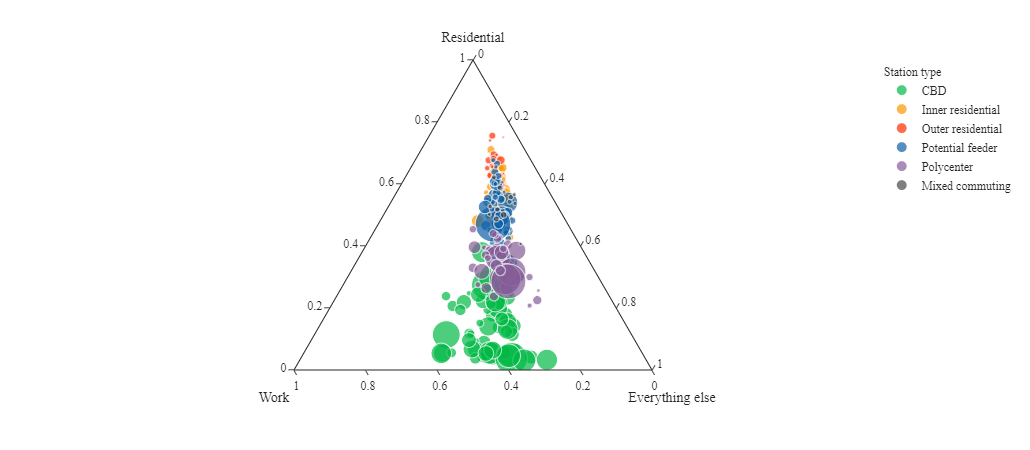

In [55]:
fig = px.scatter_ternary(
    ternary_data_cluster,
    a="Residential",
    b="Work",
    c="Everything else",
    size="total",
    size_max=25,
    hover_name="station_name",
    color="Station type",
    color_discrete_map={
        "Outer residential": "#FF2C00",
        "CBD": "#00B945",
        "Polycenter": "#845B97",
        "Inner residential": "#FF9500",
        "Potential feeder": "#0C5DA5",
        "Mixed commuting": "#474747"
    },
    template='simple_white'
)
fig.update_layout(font=dict(family="sans serif", size=12))
fig.show()
fig.write_image("../figures/fig3b1.svg")

### b). Behavioral grouping

In [56]:
ternary_data = pd.read_csv('../data/interim/ternary_data.csv')

In [57]:
ternary_data["Typical commuters"] = ternary_data.loc[:, ["1", "2"]].sum(axis=1)
ternary_data["Midday travellers"] = ternary_data.loc[:, ["0", "3"]].sum(axis=1)
ternary_data["Night time travellers"] = ternary_data.loc[:, ["4", "5"]].sum(axis=1)
ternary_data_cluster = pd.merge(ternary_data, entry_station_cluster.drop("total", axis=1), on="station_name")

ternary_data_cluster = ternary_data_cluster.loc[:,["station_name", "Typical commuters", "Midday travellers", "Night time travellers", "total", "label_name"]]
ternary_data_cluster = ternary_data_cluster.rename({"label_name": "Station type"}, axis=1)

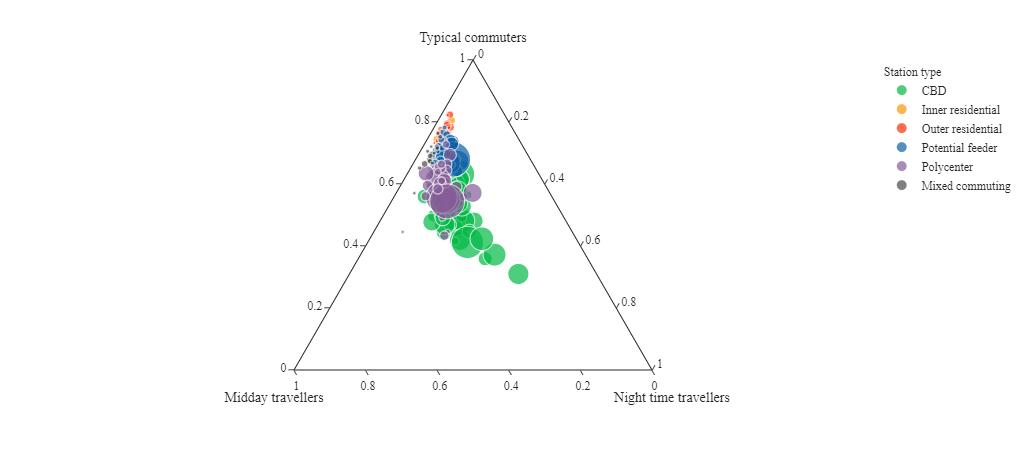

In [58]:
fig = px.scatter_ternary(
    ternary_data_cluster,
    a="Typical commuters",
    b="Midday travellers",
    c="Night time travellers",
    size="total",
    size_max=25,
    hover_name="station_name",
    color="Station type",
    color_discrete_map={
        "Outer residential": "#FF2C00",
        "CBD": "#00B945",
        "Polycenter": "#845B97",
        "Inner residential": "#FF9500",
        "Potential feeder": "#0C5DA5",
        "Mixed commuting": "#474747"
    },
    template='simple_white'
)
fig.update_layout(font=dict(family="sans serif", size=12))
fig.show()
fig.write_image("../figures/fig3b2.svg")

## 5. Explore obtained clustering parameters

In [9]:
# Load the data
n_components = 6
data_type = 'entry'

labels = np.load(f"../data/interim/gmm/individual_traces/labels_{n_components}_{data_type}.npy", allow_pickle=True)
weights = np.load(f"../data/interim/gmm/individual_traces/weights_{n_components}_{data_type}.npy", allow_pickle=True)
probs = np.load(f"../data/interim/gmm/individual_traces/probs_{n_components}_{data_type}.npy", allow_pickle=True)
means = np.load(f"../data/interim/gmm/individual_traces/means_{n_components}_{data_type}.npy", allow_pickle=True)
covariances = np.load(f"../data/interim/gmm/individual_traces/covariances_{n_components}_{data_type}.npy", allow_pickle=True)

entry_station = gpd.read_file('../data/interim/counts/entry_station_cluster_distance.json')

entry_individual = pd.read_csv("../data/interim/counts/entry_individual.csv")
entry_individual['label'] = labels
entry_individual = entry_individual.reset_index(drop=True)

In [10]:
df = pd.concat([entry_individual['station'], pd.DataFrame(probs)], axis=1)

In [11]:
# Check whether probabilities sum to 1
df.groupby('station').mean().sum(axis=1).sum()/264

0.9999318293773339

In [12]:
station_probs = df.groupby('station').mean()
station_probs = pd.merge(station_probs, entry_station[['station_name', 'total', 'distance']], left_on=station_probs.index, right_on='station_name')

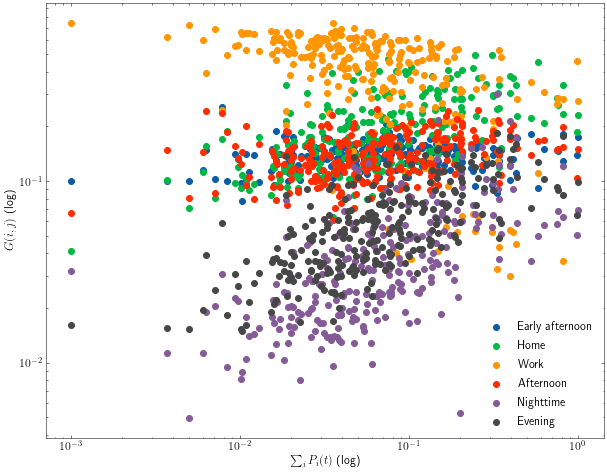

In [22]:
plt.figure(figsize=(10, 8))
n_clusters = 6
for k in range(0, n_clusters):
    plt.scatter(station_probs['rank'], station_probs[k], label=f'{label_names[k]}')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel("$G(i,j)$ (log)") #, fontsize=12)
    plt.xlabel(r'$\sum_i P_i(t)$ (log)') # , fontsize=12)
plt.legend();
plt.savefig('../figures/sfig8.png', dpi=300)